In [21]:
import logging
import re
import pandas as pd
import numpy as np

from dataclasses import dataclass
from datetime import date, datetime, timezone, timedelta
from typing import Dict, List
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import ASYNCHRONOUS
from pandas import DataFrame
from IPython.display import clear_output
import matplotlib.pyplot as plt
from termcolor import colored

#from scc_co2_buz.domain.models.well_data import IO
from scc_co2_buz.helpers.utils.io_normalize import db_types 
from scc_co2_buz.helpers.utils.get_utc import get_utc_now
from scc_co2_buz.domain.models.tag import TagModel

In [2]:
# due to changes during tests some well tags are changed
map_to_tag = {'9-BUZ-11-RJS': 'well injection C', 
              '9-BUZ-35-RJS':'well injection D',
              '9-BUZ-3-RJS':'well injection C',
              '9-BUZ-4-RJS':'well injection D'}

class InfluxDbConfig:
    """"
    ConfigClass for InfluxDb
    """
    def __init__(self) -> None:
        self.url = "http://10.136.226.25:8086"
        self.token = "ganimede@2050"
        self.org = "PETROBRAS"
        self.bucket = "vip"
        self.write_options = ASYNCHRONOUS

class InfluxDBadapter:
    def __init__(self, config: InfluxDbConfig) -> None:
        self.config = config
        self.client = InfluxDBClient(config.url, config.token, debug=None, org=config.org)
        self.log = logging.getLogger(name='repository')
        print("connecting to P-77 database...")
    def closeConnection(self):
        self.client.close()
        self.log.info('connection to database closed')
    def AddTag(self, tag: TagModel) -> Dict[bool, Exception]:
        try:
            _point = self.makeTagPoint(tag)
            self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, record=[_point], org=self.config.org)
            self.log.info('tag ' + tag.tag + ' sent to database')

        except Exception as e:
            msg = 'error sending tag ' + tag.tag + ' to database ' + e.args
            self.log.error(msg)
            return None, e
        return (True, None)

    def addAllTags(self, tags: List[TagModel]) -> Dict[bool, Exception]:
        try:
            points = [self.makeTagPoint(t) for t in tags]
            db = self.client.write_api(
                write_options=self.config.write_options).write(bucket=self.config.bucket, org=self.config.org, record=points)
            db.get()
        except Exception as e:
            msg = 'error sending tags to database ' + str(e)
            self.log.error(msg)
            return None, e
        return (True, None)

    def makeTagPoint(self, tag: List[TagModel]) -> Point:
        tag_field = 'DIAGNOSTIC' if tag.io in [
            IO.HEARTBEAT, IO.GENERALDIAG] else 'well'
        return Point("IO").tag(tag_field, tag.wn).field(tag.io, db_types[tag.io](tag.value)).time(tag.timestamp)

    def getData(self, start: date, end: date, tags:[TagModel] = None) -> DataFrame:
        params = {
            "start":  datetime.fromtimestamp(datetime.timestamp(start), tz=timezone.utc),
            "stop": datetime.fromtimestamp(datetime.timestamp(end), tz=timezone.utc),
            "bucket": self.config.bucket
        }
        filter_io = ''
        db_cols = list(set([tag.io for tag in tags]))
        for io in db_cols:
            if io != db_cols[-1]:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\" or '
            else:
                filter_io = filter_io + f'r[\"_field\"] == \"{io}\"'
        query = 'from(bucket: bucket)\
            |> range(start: start, stop: stop)\
            |> filter(fn: (r) => r["_measurement"] == "IO")\
            |> filter(fn: (r) => ' + filter_io + ')\
            |> yield(name: "last")'
        query_api = self.client.query_api()
        result = query_api.query(
            org=self.config.org, query=query, params=params)
        results = []
        for table in result:
            for record in table.records:
                results.append((datetime.fromtimestamp(
                    record.get_time().timestamp(), tz=timezone.utc), record.get_value(), record['well'], record.get_field()))
        df = pd.DataFrame(data=results, columns=['time', 'value', 'oil_well', 'io'])
        df2 = df.pivot(index=['time', 'oil_well'], columns=['io'], values=['value']).reset_index()
        df2.columns = [c[{'time': 0, 'oil_well': 0, 'value': 1}[c[0]]] for c in df2.columns]
        return df2
    
@dataclass
class Color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = "\033[1;32;48m"
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

def print_colored(msg:str, color: Color = Color.GREEN):
    print("{} {} {}".format(color,msg, Color.END))
def calcNormStd(df, well, pit, delta = timedelta(seconds=60)):
    start = df['time'].min()
    end = start + delta
    max_norm_std = -1.0
    
    time_limit = df.iloc[-1]['time'] - delta
    iteration = 0
    total_iterations = int((time_limit.timestamp() - start.timestamp()) / 60 )    
    values = []
    iterations = []
    #time_limit = 1000 * delta + start
    max_sample_data = None
    
    while start <= time_limit:
        mask = (df['oil_well'] == well) & (df['time'] >= start) & (df['time'] < end) 
        current_data = df.loc[mask][pit]
        current_norm_std = current_data.std() / current_data.mean()
        iteration += 1
        clear_output(wait=True)
        msg = f'iteration = {iteration} \n > progress = {100*iteration/total_iterations if iteration < total_iterations else 100.00} %'
        color = "green"
        print_colored(msg, Color.GREEN)
        if current_norm_std > max_norm_std:
            max_norm_std = current_norm_std 
            values.append(max_norm_std) 
            iterations.append(iteration)
            print(max_norm_std)
            max_sample_data = current_data
        start = start + delta
        end = end + delta
        
    df_std = pd.DataFrame({'iteration': iterations, 'variation': values})
    df_std.plot(x='iteration', y='variation', kind='line')
    plt.show()    
    return f'coefficient of variation = {100*max_norm_std} %'

def toFloat(x):
    
    if type(x) == float or type(x) == int:
        return x
    
    x = x.strip()
    x = x.replace(' ','')
    
    result1 = None
    result2 = None
    
    try:
        result1 = re.findall(r'\d+\.\d+', x)
        result2 = re.findall(r'\d+', x)
    except Exception as e:
        return np.nan
        
    if len(result1) > 0 and type(result1) == list:
        return float(result1[0])
    elif len(result2) > 0 and type(result2) == list:
        return float(result2[0])
    else:
        # comm fail from PI Web API
        return np.nan

def checkSupress(supression, time_):
    # supression.name.split('_')[0] in 'SDY_1210002' and
    if len(supression) > 0 and supression.iloc[-1] == 0:
        print_colored(' > supressed by ' + supression.name + '\n  in time: ' + str(time_) + '\n  with status : ' + str(supression.iloc[-1]), Color.YELLOW)
        return True 
    variation = 100 * ( supression.max() - supression.min() ) / (supression.mean() + 0.0000000001)
    if variation >= 2.0:
        print_colored(' > supressed by ' + supression.name + '\n  in time: ' + str(time_) + '\n  with variation : ' + str(variation) + ' %', Color.YELLOW)
        return True
    return False   

def normalize_data(df):
    
    for col in df.columns:
        if col not in ['time','oil_well']:
            if col.split('_')[0] in ['SDY', 'ZSH', 'ZSL' ]:
                df[col] = df[col].apply(lambda x: 1 if x  else 0)
            else:
                
                df[col] = df[col].apply(lambda x: toFloat(x))
                #std = df[col].std()
                #mean = df[col].mean()
                #df[col] = df[col].apply(lambda x: (x - mean) / (std + 0.000000000001))
        else:
            if col == 'time':
                df[col] = df[col].apply(lambda x: datetime.strptime(x.split('+')[0], '%Y-%m-%d %H:%M:%S.%f') - timedelta(hours=3)) 

            
    #df = df.dropna()
    return df

class Signal:
    def __init__(self):
        self.io_input = []
        self.io_ouput = []
        self.alarm_values = [0,0,0,0,0,0]
        self.sample_values = [0,0,0,0,0,0]
        self.values = [0,0,0,0,0,0,0,0,0]
        
    def check_alarm(self, df, instrument_supress, time_, i, v, set_point_ll = -67 * 100):
        
        self.alarm_values.append(1.0 if v <= set_point_ll else 0.0 ) 
        self.alarm_values.pop(0)
        self.sample_values.append(v)
        self.sample_values.pop(0)  
        
        check = 0         

        if sum(self.alarm_values) == 6:   
    
            # select data for supression
            start = time_ - timedelta(seconds = 90) 
            end = time_
            
            ## code repetition for n supressions
            print_colored(f'\ntime range > {start} , {end}',Color.BLUE)
            
            isForSupress = 0
            for supres in instrument_supress:
                mask = (df[supres].notnull()) & (df['time'] >= start) & (df['time'] <= end)
                supression = df.loc[mask][supres]
                
                #print(supression)
                print(supression.max(), supression.min(), len(supression))
                
                if checkSupress(supression, time_):
                    isForSupress += 1
                    
            check = 0 if isForSupress > 0 else 1
            
            # print alarm
            color = Color.RED if check == 1 else Color.GREEN
            print_colored('iter = '+ str(i), color)
            print_colored('time = '+ str(time_), color)
            print_colored('signal inputs '+ str(self.values) + ' kPa', color)
            print_colored('signal outputs'+ str(self.sample_values) + ' kPa/min',color)
            self.alarm_values = [0,0,0,0,0,0]
            self.sample_values = [0,0,0,0,0,0]
       
        return check
    
    def signalFilter(self,df,instrument,instrument_supress,coef = [-4,-3,-2,-1,0,1,2,3,4],gain = 1.0):
        
        delta_sec = 5       
        mask = df[instrument].notnull()
        current_data = df.loc[mask][instrument]
        current_time = df.loc[mask]['time']
        
        total_iterations = int(len(current_data) * 1)
        iter_out = []
        status_in_alarm = 0
        alarms = []
        
        print_colored('total iterations ' + str(total_iterations), Color.BLUE )
        
        for i in range(total_iterations):
            iter_out.append(i)
            self.io_input.append(current_data.iloc[i]) 
            out_ = 0
            self.values.append(current_data.iloc[i])
            self.values.pop(0)
            for c, v in  zip(coef,self.values):
                out_  +=  c * v
            filtered = gain * out_ / delta_sec
            self.io_ouput.append(filtered) 
            alarms.append(self.check_alarm(df, instrument_supress, current_time.iloc[i], i, filtered))
        
        # plot fig size
        size = (18,6)
        # alarm
        alm = DataFrame({'time':iter_out,'alarms': alarms})
        alm.plot(x='time',y='alarms', kind='line', figsize=size)
        
        # input signal
        df_input = DataFrame({'time': iter_out, instrument: self.io_input})
        df_input.plot(x='time', y=instrument, kind='line', figsize=size)
        
        # supress signals
        for suprs in instrument_supress:
            mask = df[suprs].notnull()
            df.loc[mask].plot(x='time', y=suprs, kind='line', figsize=size)        
        
        # filtered signal
        result = DataFrame({'time':iter_out,'filtered_signal': self.io_ouput})
        result.plot(x='time',y='filtered_signal', kind='line', figsize=size)        
        
        # print alarms
        total_alarms = alm.sum().values[1]
        color = Color.RED if total_alarms >= 1 else Color.GREEN
        print_colored('total alarms =  ' + str(total_alarms), color)
        
        return result 

def merge_cols(df):
    
    df['ZIT_1244002'] = df.apply( lambda x: x['ZIT_1244002_1'] if not np.isnan(x['ZIT_1244002_1']) else x['ZIT_1244002_2'] , axis=1)

    df['ZSH_1210002'] = df.apply(lambda x: x['ZSH_1210002_1'] if not np.isnan(x['ZSH_1210002_1']) else (x['ZSH_1210002_2'] if not np.isnan(x['ZSH_1210002_2']) else x['ZSH_1210002_3']) , axis=1)

    df = df.drop(['ZIT_1244002_1', 'ZIT_1244002_2' ,'ZSH_1210002_1', 'ZSH_1210002_2' , 'ZSH_1210002_3'], axis=1)
    
    return df
    
    
def make_well_data(df, wells=['well injection C',  'well injection D']):
   
    df_result = DataFrame()
    for well in wells:
        l = well.split(' ')[2]
        mask = (df['oil_well'] == well)
        df_result = df_result.append(DataFrame({
        'time' : df.loc[mask]['time'].values,
        'ZIT_1244002' + l: df.loc[mask]['ZIT_1244002'].values,
        'PIT_1244007' + l: df.loc[mask]['PIT_1244007'].values,
        'PIT_1244008' + l: df.loc[mask]['PIT_1244008'].values,
        'SDY_1210002' + l: df.loc[mask]['SDY_1210002'].values,
        'ZSH_1210002' + l: df.loc[mask]['ZSH_1210002'].values,
        'ZSL_1210002' + l: df.loc[mask]['ZSL_1210002'].values}))
    return df_result



In [3]:
columns = {'P-JUZ-CKP-A': "PIT_1244007", 
           'P-JUZ-CKP-B': "PIT_1244008",
           'ESTADO-POCO':'ZSH_1210002_1',
           'SDV':'ZSH_1210002_2',
           'ZSH': 'ZSH_1210002_3',
           'ZSL': 'ZSL_1210002',
           'ABER-CKP': 'ZIT_1244002_1',
           'CHOKE': 'ZIT_1244002_2',
           'CMD': 'SDY_1210002'}

tags = list( map( lambda io: TagModel(paths=None,tag=None, io=io), columns.keys()))
end = get_utc_now()
start = get_utc_now() - timedelta(seconds=60*60*24*15) #timedelta(seconds=259200)

In [4]:
#repo = InfluxDBadapter(config=InfluxDbConfig())
#df = repo.getData(start=start,end=end,tags=tags)

In [5]:
#mask = (df['oil_well'].apply(lambda v: v in map_to_tag.keys()))
#df = df.loc[mask].copy()
#df['oil_well'] = df['oil_well'].apply(lambda x: map_to_tag[x])
#df = df.rename(columns=columns)
#df_select = df.query('oil_well=="well injection C" or oil_well == "well injection D"')
#df_select

In [6]:
#df_select.to_csv("output_data.csv", index= False)
#calcNormStd(df, 'well injection D', 'PIT_1244008')

In [19]:
df = pd.read_csv("output_data.csv",low_memory=False)

In [20]:
df = normalize_data(df)
df = merge_cols(df)
df = make_well_data(df)
df #= pd.read_csv("input_data.csv")

,time,ZIT_1244002C,PIT_1244007C,PIT_1244008C,SDY_1210002C,ZSH_1210002C,ZSL_1210002C,ZIT_1244002D,PIT_1244007D,PIT_1244008D,SDY_1210002D,ZSH_1210002D,ZSL_1210002D
0,2022-11-20 08:12:08.214074,NaN,29631.160156,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-20 08:12:13.679842,NaN,29639.750000,29742.800781,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-20 08:12:18.877836,NaN,29635.460938,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-11-20 08:12:24.329523,NaN,29635.460938,29742.800781,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-20 08:12:29.787124,NaN,29631.160156,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293286,2022-12-05 08:11:40.908940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39446.679688,39399.449219,1.0,1.0,0.0
293287,2022-12-05 08:11:51.031088,NaN,NaN,NaN,NaN,NaN,NaN,18.318750,NaN,NaN,1.0,1.0,1.0
293288,2022-12-05 08:11:51.842478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39433.800781,39386.558594,1.0,1.0,0.0
293289,2022-12-05 08:12:01.913167,NaN,NaN,NaN,NaN,NaN,NaN,18.325001,NaN,NaN,1.0,1.0,1.0


 total iterations 149065 
 
time range > 2022-12-01 15:45:22.276570 , 2022-12-01 15:46:52.276570 
45.5625 18.237499237060547 12
  > supressed by ZIT_1244002D
  in time: 2022-12-01 15:46:52.276570
  with variation : 119.86566436330907 % 
1.0 1.0 22
1.0 0.0 22
  > supressed by SDY_1210002D
  in time: 2022-12-01 15:46:52.276570
  with status : 0.0 
 iter = 116028 
 time = 2022-12-01 15:46:52.276570 
 signal inputs [37055.05859375, 36028.84765625, 35127.16015625, 34371.4609375, 33559.953125, 32890.12109375, 32289.0, 32426.400390625, 32542.330078125] kPa 
 signal outputs[-7585.34140625, -8983.3796875, -9853.2921875, -10034.4859375, -9007.415625, -7203.183203125] kPa/min 
 
time range > 2022-12-01 22:27:05.772309 , 2022-12-01 22:28:35.772309 
8.274999618530273 0.0 11
  > supressed by ZIT_1244002D
  in time: 2022-12-01 22:28:35.772309
  with status : 0.0 
1.0 1.0 20
1.0 0.0 20
  > supressed by SDY_1210002D
  in time: 2022-12-01 22:28:35.772309
  with variation : 111.11111109876543 % 
 iter = 

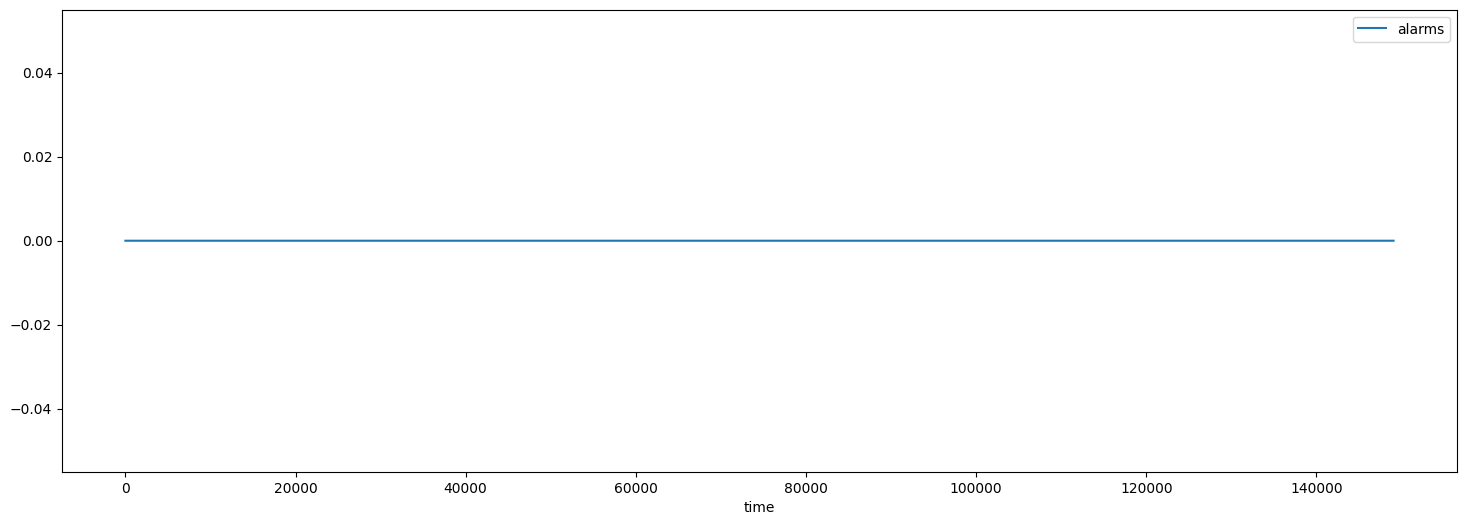

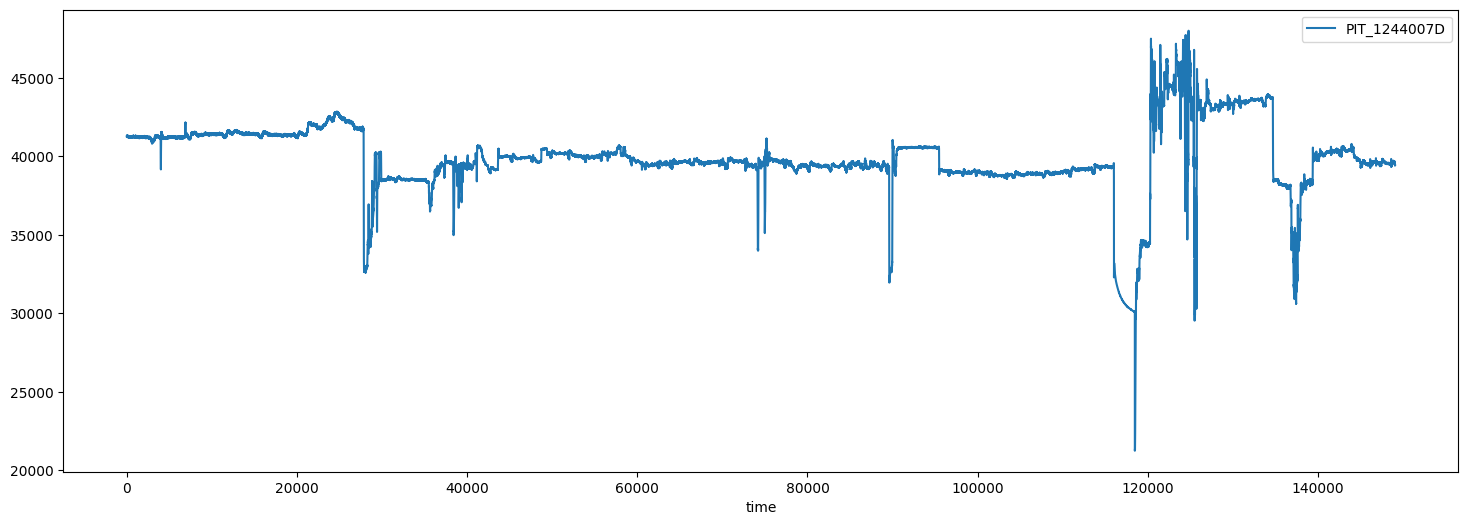

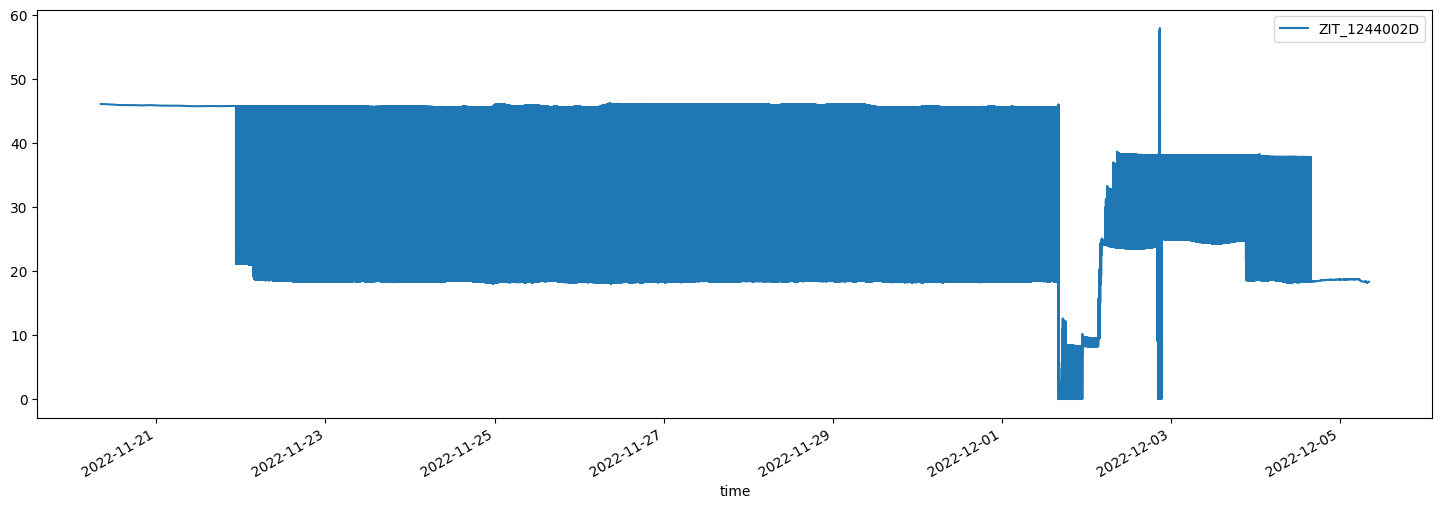

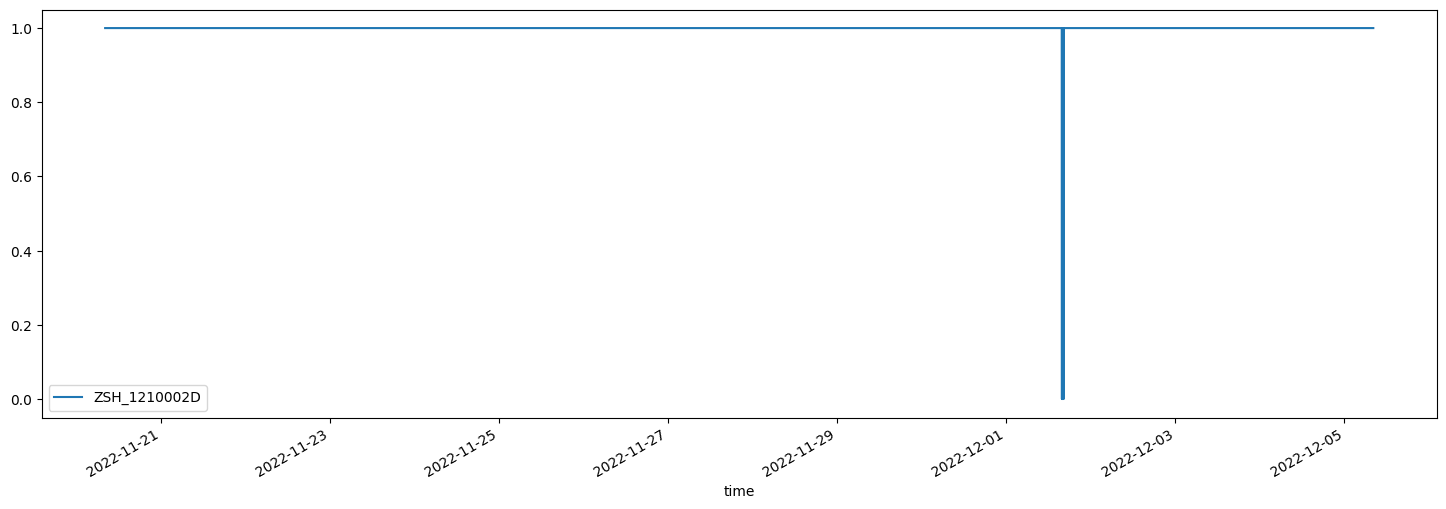

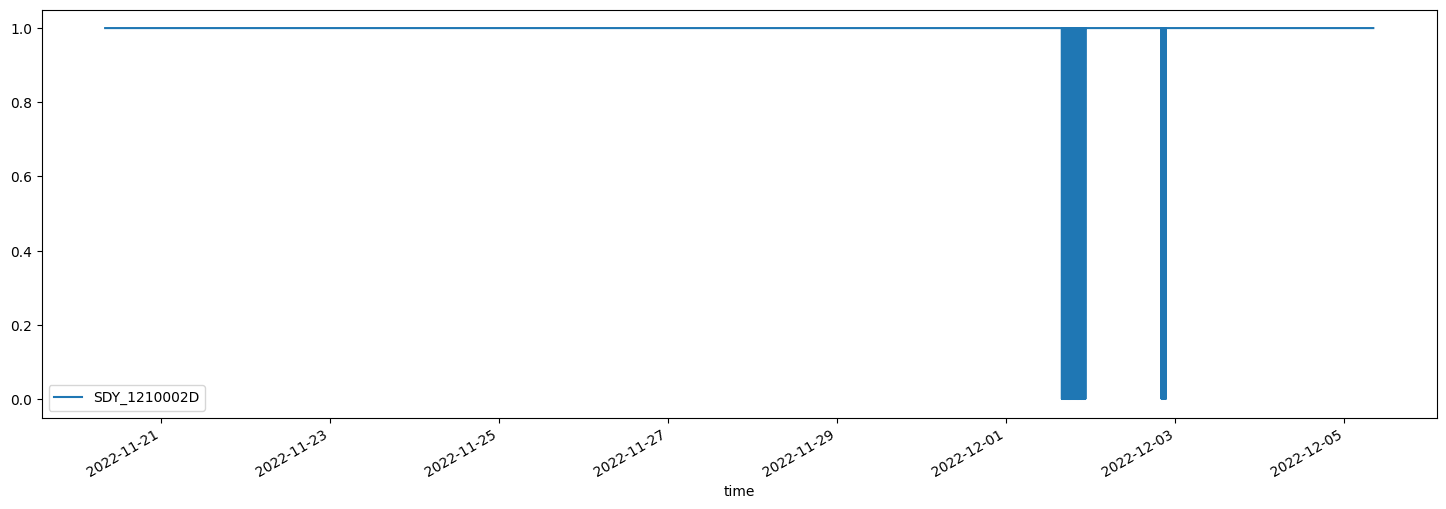

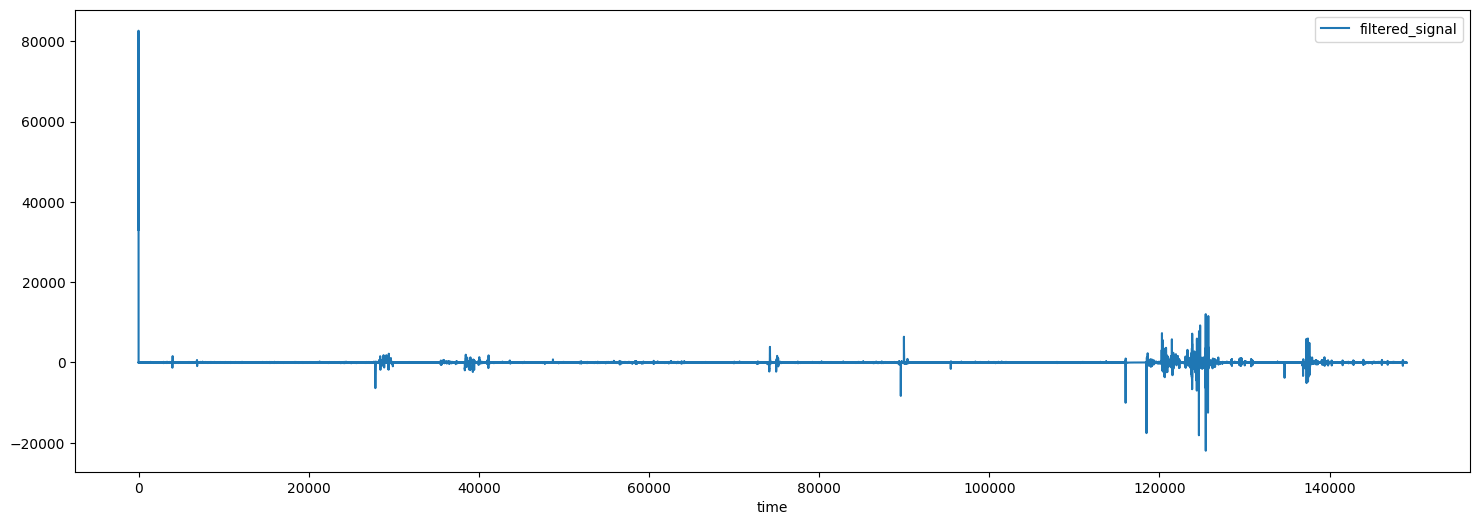

In [23]:
result = Signal().signalFilter(df,'PIT_1244007D', ['ZIT_1244002D', 'ZSH_1210002D', 'SDY_1210002D'])

 total iterations 149065 
 
time range > 2022-12-01 22:41:02.679232 , 2022-12-01 22:42:32.679232 
0.0 0.0 9
  > supressed by ZIT_1244002C
  in time: 2022-12-01 22:42:32.679232
  with status : 0.0 
1.0 1.0 9
1.0 0.0 9
  > supressed by SDY_1210002C
  in time: 2022-12-01 22:42:32.679232
  with variation : 128.57142855489795 % 
 iter = 118563 
 time = 2022-12-01 22:42:32.679232 
 signal inputs [34126.71875, 34178.24609375, 34229.76953125, 20605.69921875, 20816.099609375, 20644.349609375, 20803.2109375, 20682.990234375, 20751.689453125] kPa 
 signal outputs[-10336.7734375, -18411.5984375, -23959.980078125, -26677.066796875, -26804.164453125, -24160.0703125] kPa/min 
 
time range > 2022-12-02 20:16:32.527209 , 2022-12-02 20:18:02.527209 
3.299999952316284 0.0 8
  > supressed by ZIT_1244002C
  in time: 2022-12-02 20:18:02.527209
  with status : 0.0 
1.0 1.0 8
1.0 1.0 8
 iter = 125436 
 time = 2022-12-02 20:18:02.527209 
 signal inputs [36909.0703125, 37295.51171875, 30584.380859375, 29639.75,

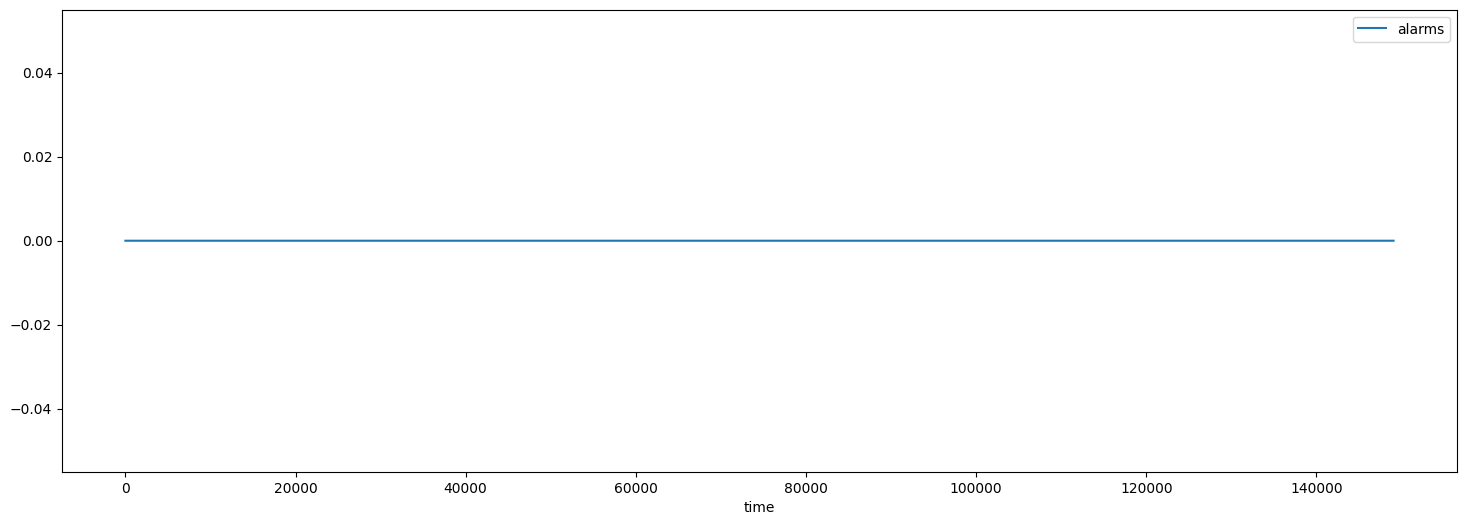

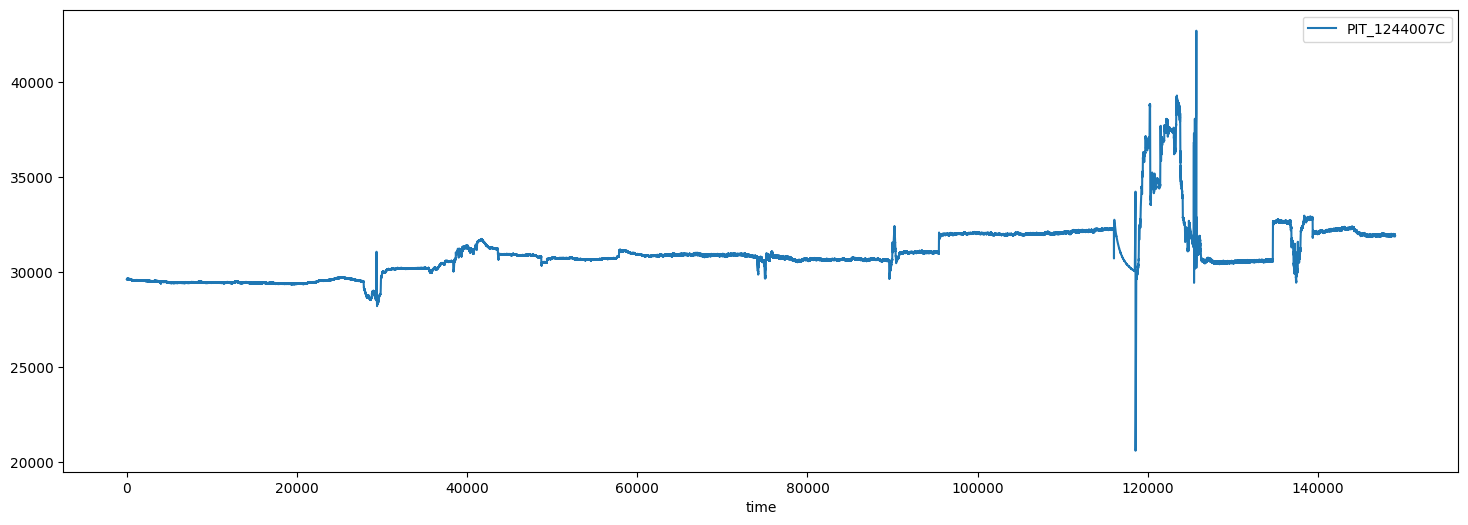

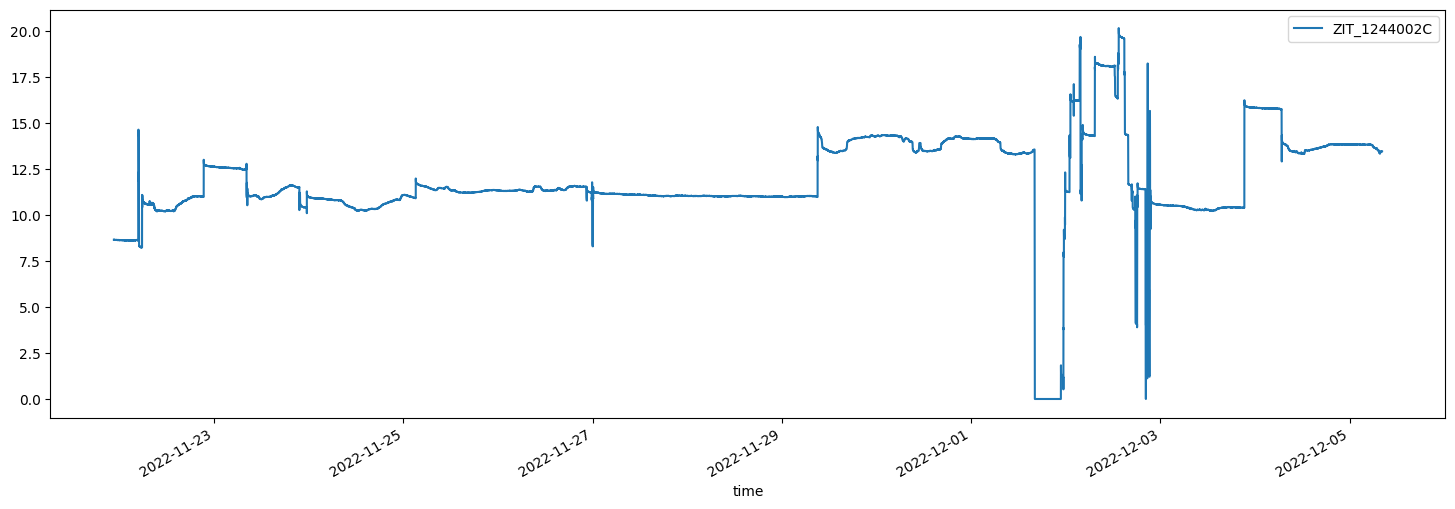

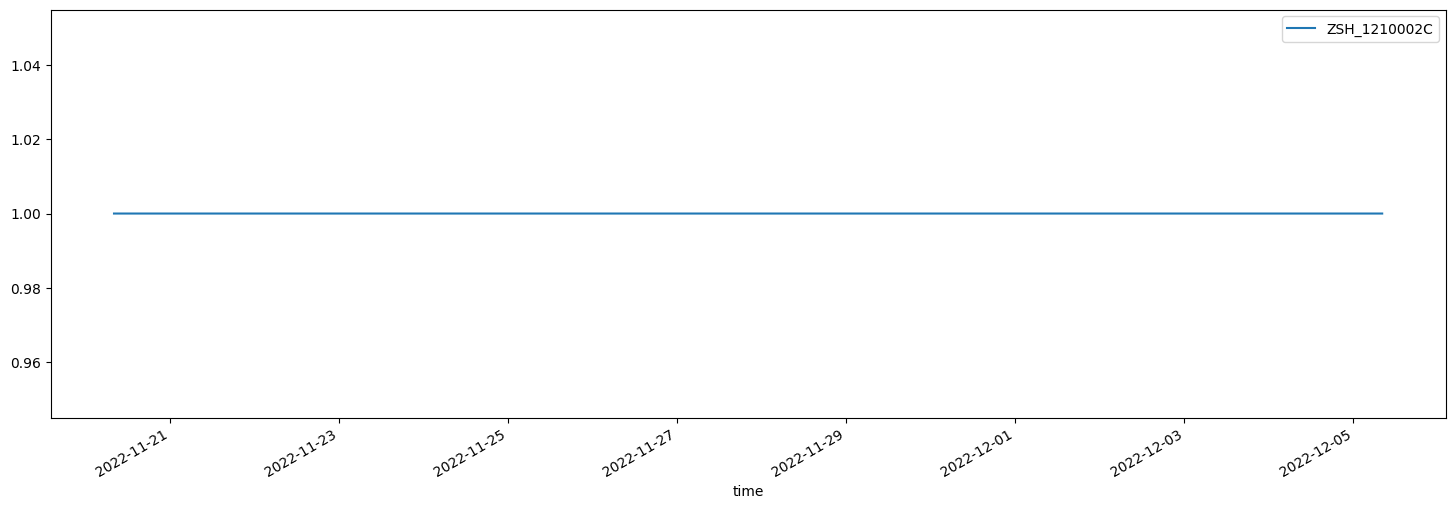

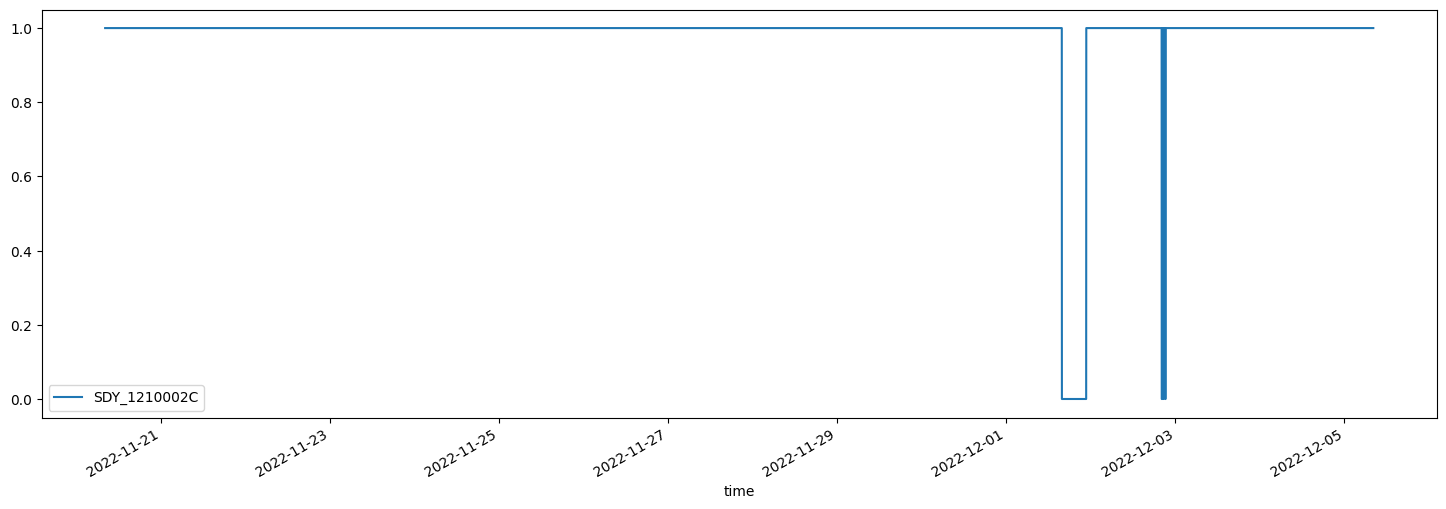

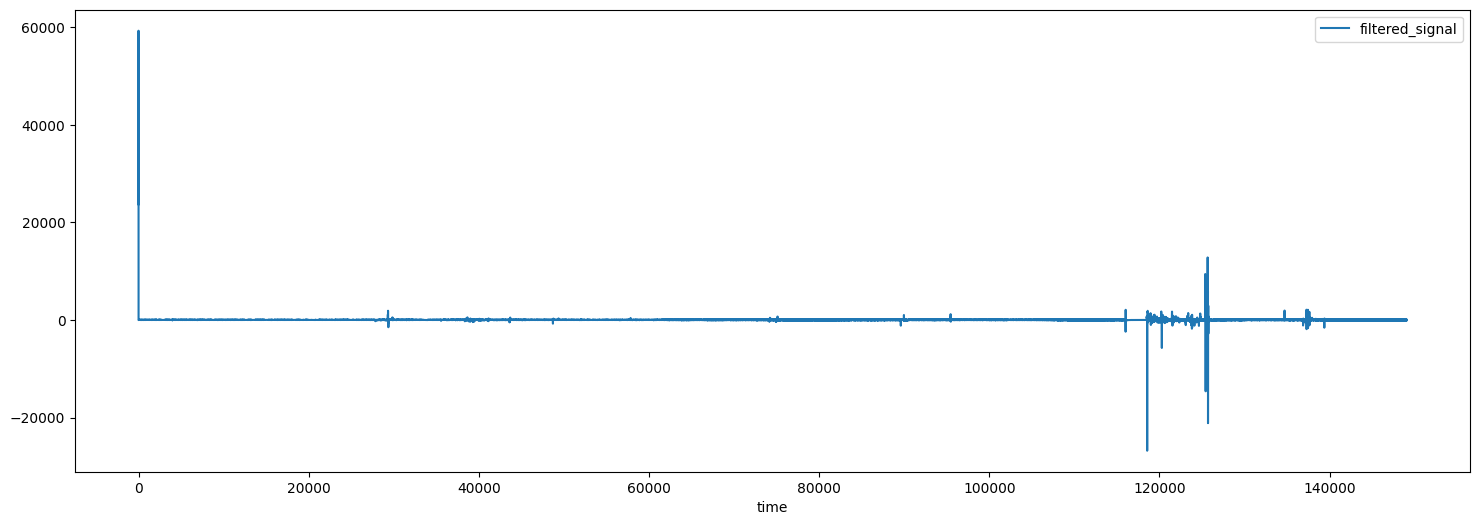

In [22]:
result = Signal().signalFilter(df,'PIT_1244007C' , ['ZIT_1244002C','ZSH_1210002C', 'SDY_1210002C'])

In [11]:
df.head()

,time,ZIT_1244002C,PIT_1244007C,PIT_1244008C,SDY_1210002C,ZSH_1210002C,ZSL_1210002C,ZIT_1244002D,PIT_1244007D,PIT_1244008D,SDY_1210002D,ZSH_1210002D,ZSL_1210002D
0,2022-11-20 08:12:08.214074,NaN,29631.160156,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-20 08:12:13.679842,NaN,29639.750000,29742.800781,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-11-20 08:12:18.877836,NaN,29635.460938,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-11-20 08:12:24.329523,NaN,29635.460938,29742.800781,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-11-20 08:12:29.787124,NaN,29631.160156,29738.509766,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
